# OH Differential Election Analysis
Beckett76

The following represents an analysis of OH county voting patterns between 2000 and 2020. The results are included in the report "Analysis of Voting Anomalies in Several States" located at https://github.com/beckett76/election_analysis.

The primary data plotted in this analysis are differences of percentage point scores in each county for the Republican presidential candidate between two elections. For example, if Bush won a county with 60% of the vote in 2000 and 66% of the vote in 2004, this would show up as a +6% on the plot.

The consistent structure of the anomalies has lead the author to hypothesize a vote changing scheme which follows the equation:
$$
\Delta{R_i} =  \begin{cases} 
      k \log_{10} (\frac{T_i}{T_0})& T_i \geq T_0 \\
      0 & T_i \le T_0
   \end{cases}
$$
where $\Delta R_i$ are the number of changed R votes in the county and $T_i$ are the total votes in the county. The onset (intercept) parameter $T_0$ indicates the critical county size at which the algorithm begins, and $k$ is the slope of the algorithm (against log of county size).

In the report, the author has developed a parameter fitting method which involves reading the slope $k$ off a log-log plot. The data plotted are the natural log of the ratio of R percentage points between two elections vs the log base 10 of the total votes in a given county. These plots are denoted as the "log ratio" plot. See the report for more details.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Load the data. (For this state, I did most of the hard work in Excel).

In [2]:
state = 'OH'

yrs = np.arange(2000,2024,4)
data = {}
for yr in yrs:
    file = f".\{state}_{yr:d}.xlsx"
    data[yr] = pd.read_excel(file,sheet_name='Export')
        
    # calculate percentages of vote
    data[yr]['Rp'] = data[yr]['R']/data[yr]['Total']
    data[yr]['Dp'] = data[yr]['D']/data[yr]['Total']

We will define a county as "blue" or "red" based on how they voted in '08 (approximately the midpoint of the analysis). Red represents >=50% Republican presidential vote and blue otherwise.

In [3]:
sR = data[2008]['Rp'] > 0.5 # Red county label
sB = ~sR # Blue county label

Now we will define the plot types to be used

In [4]:
# difference plot
def plot_diff(yr1,yr2,L=0.2,xL=None):
    """
    Plot the difference of election percentage points by county between two years.
    
    yr1 is the first year (key in data)
    yr2 is the second year (key in data)
    L is optional Y axis limit (symmetric)
    """
    tot = data[yr2]['Total']
    plt.semilogx(tot[sR], data[yr2]['Rp'][sR]-data[yr1]['Rp'][sR], 'r.')
    plt.semilogx(tot[sB], data[yr2]['Rp'][sB]-data[yr1]['Rp'][sB], 'b.')
    plt.grid()
    plt.ylim([-L,L])
    if xL is not None:
        plt.xlim(xL)
    plt.xlabel(f'Total Votes - {yr2}')
    plt.ylabel(f'% R {yr2} - % R {yr1}')
    plt.title(f'Difference in R Support in {state} Counties: {yr1} - {yr2}')
    plt.show()
    
def plot_log_ratio(yr1,yr2,L=0.4):
    """
    Plot the log ratio metric (for determining algorithm parameters) between two years.
    
    yr1 is the first year (key in data)
    yr2 is the second year (key in data)
    L is optional Y axis limit (symmetric)
    """
    tot = data[yr2]['Total']
    plt.semilogx(tot[sR], np.log(data[yr2]['Rp'][sR]/data[yr1]['Rp'][sR]), 'r.')
    plt.semilogx(tot[sB], np.log(data[yr2]['Rp'][sB]/data[yr1]['Rp'][sB]), 'b.')
    plt.grid(which="both", ls="-") # nice fine grid lines
    plt.xlabel(f'Total Votes - {yr2}')
    plt.ylabel(f'Ln PP Ratio {yr2}/{yr1}')
    plt.title(f'Log Ratio in R Support in {state} Counties: {yr1} - {yr2}')
    plt.show()

Now we define the function to back out the (conjectured) vote changes.

In [5]:
def adjust_yr(d,k,T0=1e4):
    """
    Adjust data set d to remove the effects of algorithm with parameters `k` and `T_0`.
    Return the total number of changed votes.
    (This function will operate on the data in-place.)
    """
    Lt = np.log10(d['Total'])
    Lt0 = np.log10(T0)
    rho = (Lt - Lt0) * ((Lt - Lt0) > 0) * k # this is the predicted vote change fraction by county
    dR = rho/(1-rho) * d['R'] # predicted total votes changed
    # make the adjustement and recalculate the % vote
    d['R'] += dR
    d['D'] -= dR
    d['Rp'] = d['R']/d['Total']
    d['Dp'] = d['D']/d['Total']
    return dR.sum() # return total votes changed across all counties

## Difference Plots
2000-2004 is nominal

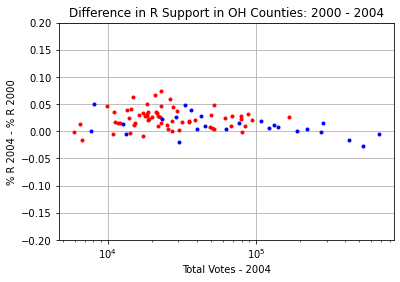

In [6]:
plot_diff(2000,2004)

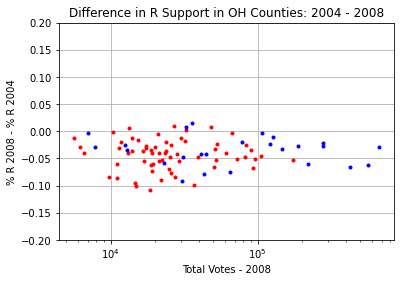

In [7]:
plot_diff(2004,2008)

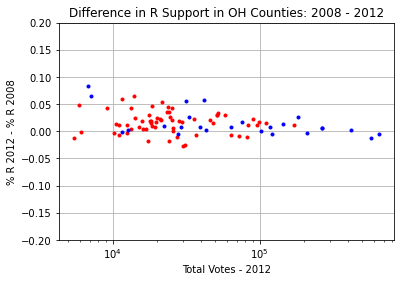

In [8]:
plot_diff(2008,2012)

Anomalies start here

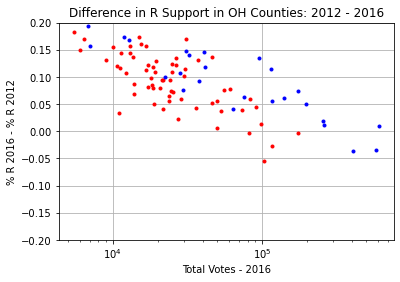

In [9]:
plot_diff(2012,2016)

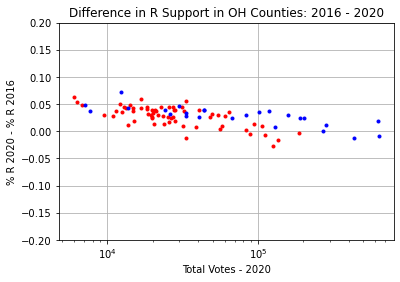

In [10]:
plot_diff(2016, 2020)

"Sanity check" plot, 2004-2020 (axes limits doubled).

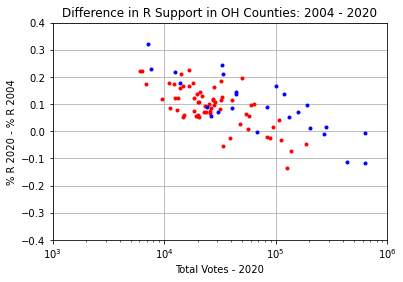

In [11]:
plot_diff(2004,2020,0.4,[1e3,1e6])

## Analysis of Algorithm Parameters

In [12]:
# a place to store our results
dfs = pd.DataFrame(
    index=[2016, 2020], 
    columns=['k','T0','dR','marginR', 'Rp', 'Rp_adj']) # summary data frame

Fix 2016.

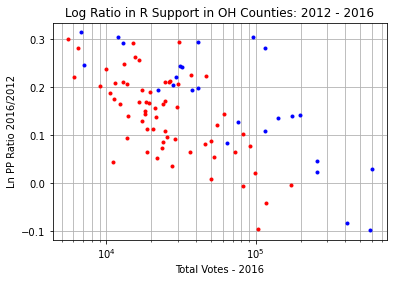

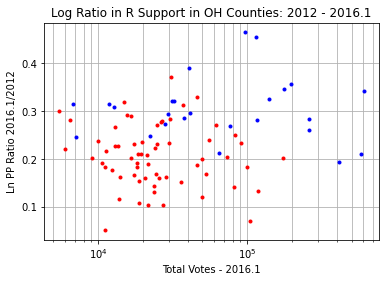

In [13]:
yr = 2016.1; yr0 = 2016
k = 0.15
T0 = 1e4

data[yr] = data[yr0].copy()
dR = adjust_yr(data[yr],k,T0)
plot_log_ratio(yr0-4,yr0)
plot_log_ratio(yr0-4,yr)

dfs.loc[yr0]['k'] = k
dfs.loc[yr0]['T0'] = T0
dfs.loc[yr0]['dR'] = dR

# calculate the original margin and adjusted %
dfs.loc[yr0]['marginR'] = data[yr0]['R'].sum() - data[yr0]['D'].sum()
dfs.loc[yr0]['Rp'] = data[yr0]['R'].sum()/data[yr0]['Total'].sum()
dfs.loc[yr0]['Rp_adj'] = (data[yr0]['R'].sum() + dR)/data[yr0]['Total'].sum()

Fix 2020 (small slope increase)

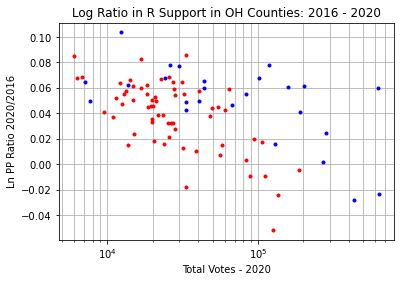

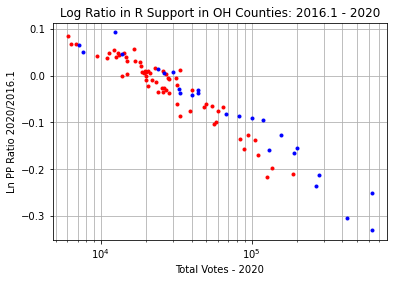

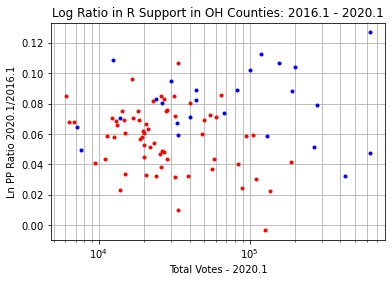

In [14]:
yr = 2020.1; yr0 = 2020
k = 0.175
T0 = 1e4

data[yr] = data[yr0].copy()
dR = adjust_yr(data[yr],k,T0)
plot_log_ratio(yr0-4,yr0)
plot_log_ratio(yr-4,yr0)
plot_log_ratio(yr-4,yr)

dfs.loc[yr0]['k'] = k
dfs.loc[yr0]['T0'] = T0
dfs.loc[yr0]['dR'] = dR

# calculate the original margin and adjusted %
dfs.loc[yr0]['marginR'] = data[yr0]['R'].sum() - data[yr0]['D'].sum()
dfs.loc[yr0]['Rp'] = data[yr0]['R'].sum()/data[yr0]['Total'].sum()
dfs.loc[yr0]['Rp_adj'] = (data[yr0]['R'].sum() + dR)/data[yr0]['Total'].sum()

# Plot Adjusted Patterns
These look much better!

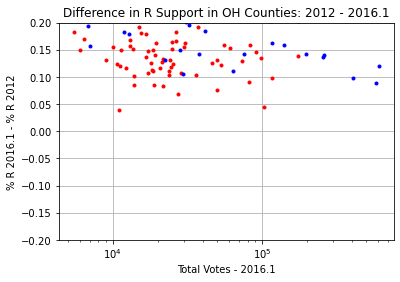

In [15]:
plot_diff(2012, 2016.1)

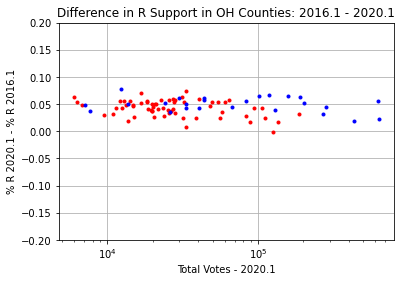

In [16]:
plot_diff(2016.1, 2020.1)

"Sanity check" plot against 2012.

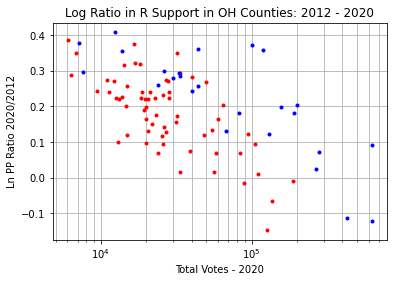

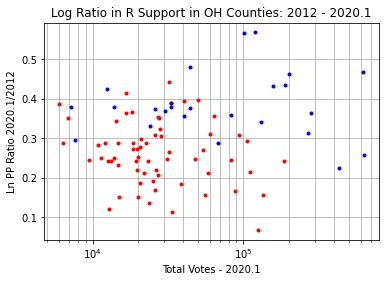

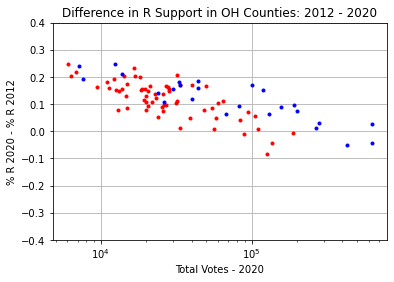

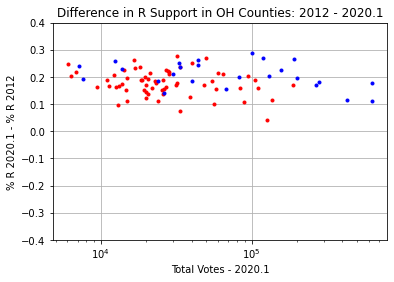

In [17]:
plot_log_ratio(2012,2020)
plot_log_ratio(2012,2020.1)
plot_diff(2012, 2020, 0.4)
plot_diff(2012, 2020.1, 0.4)

## Summary Results
Here are the summarized parameters and total votes changed by year.

In [18]:
dfs

,k,T0,dR,marginR,Rp,Rp_adj
2016,0.15,10000,520970,446841,0.516877,0.611659
2020,0.175,10000,722432,475669,0.532713,0.6547


## Benford's Law Excursion
In this analysis, we see if the changes have any effects on Benford's law.

In [19]:
# compute leading digit in base b
def leading(d,b=10):
    return d//b**(np.floor(np.log(d)/np.log(b)))

# plot against Benford's law (in base b)
def plot_benford(lead,label,b=10):    
    count,bins = np.histogram(lead,range(1,b+1))
    d = np.arange(1,b)
    plt.plot(d, count/len(lead),'-x');
    # Benford's law
    plt.plot(d, (np.log(d+1) - np.log(d))/np.log(b))
    plt.legend([label, "Benford's Law"])
    plt.title(f"Benford's Law Analysis in Base {b}: {label}")
    plt.grid(); 
    plt.show()

First, check how well total votes matches Benford. (It's not bad)

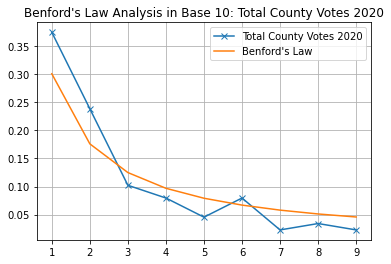

In [20]:
base = 10
yr = 2020
plot_benford(leading(data[yr]['Total'],base), f'Total County Votes {yr}', base)


See how well original R votes and modified R votes match for 2020. There is little difference.

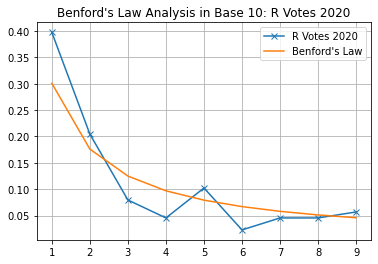

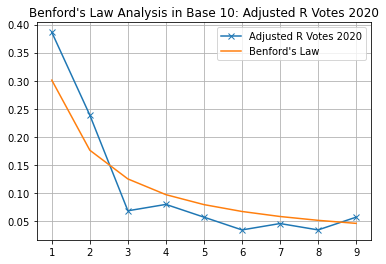

In [21]:
plot_benford(leading(data[yr]['R'],base), f'R Votes {yr}', base)
plot_benford(leading(data[yr+0.1]['R'],base), f'Adjusted R Votes {yr}', base)

Same analysis for the D votes.

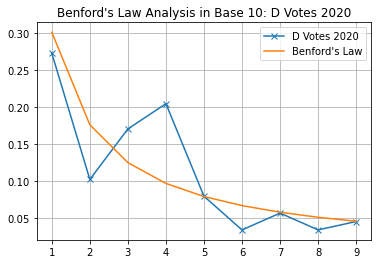

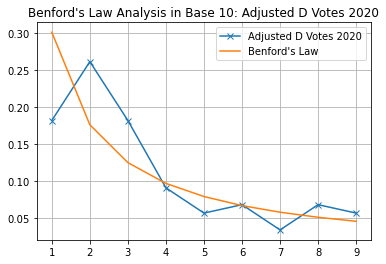

In [22]:
plot_benford(leading(data[yr]['D'],base), f'D Votes {yr}', base)
plot_benford(leading(data[yr+0.1]['D'],base), f'Adjusted D Votes {yr}', base)

See how bad it looks if we just contrive some fixed vote addition to every county. (Looks fishy)

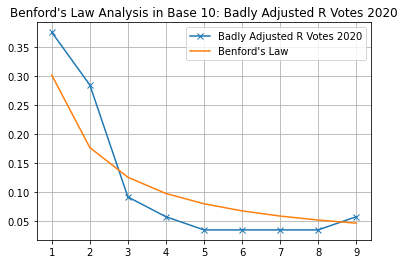

In [23]:
plot_benford(leading(data[yr]['R']+4000,base), f'Badly Adjusted R Votes {yr}', base)

## Conclusion
Read the report!

Feel free to modify the code to do additional analyses (and additional states).

Be safe and good luck out there.

# God Bless America